# New baseline with 12?

In [19]:
from pathlib import Path
import sys
import os
import numpy as np

# Had to add this stuff to get notebook to find files, because it is not
# located in the root folder
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

from keras import Sequential, Input, layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import regularizers
from keras.utils import load_img, img_to_array

from bee_tector.plots import plot_history
from bee_tector.data import (
    load_datasets,
    undersample_dataset,
    load_selected_classes
)
from bee_tector.config import (
    FULL_DATA_DIR,
    CURATED_DATA_DIR,
    MODELS_DIR,
    IMAGE_SIZE
)

In [4]:
train_ds, val_ds, test_ds = load_datasets()

Found 3619 files belonging to 12 classes.
Found 781 files belonging to 12 classes.
Found 781 files belonging to 12 classes.


In [7]:
def initialize_model(shape=(224, 224, 3)):

    model = Sequential()

    model.add(Input(shape=shape))
    model.add(layers.Rescaling(1./255))  # RESCALE!

    model.add(layers.Conv2D(32, (4, 4), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    # I don't really know what this does but you can do this instead of
    # flattening I think
    # model.add(layers.GlobalAveragePooling2D())

    reg = regularizers.l2(1e-5)
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=reg))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=reg))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(12, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

    return model


In [8]:
baseline_model = initialize_model()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = baseline_model.fit(
    train_ds,
    epochs=1000,
    validation_data=val_ds,
    callbacks=[es],
    verbose=1
)

Epoch 1/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 83s 716ms/step - accuracy: 0.0989 - loss: 3.2191 - val_accuracy: 0.0960 - val_loss: 24.9473
Epoch 2/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 704ms/step - accuracy: 0.1213 - loss: 2.8301 - val_accuracy: 0.1536 - val_loss: 8.8309
Epoch 3/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 81s 707ms/step - accuracy: 0.1456 - loss: 2.7529 - val_accuracy: 0.1191 - val_loss: 2.5923
Epoch 4/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 81s 711ms/step - accuracy: 0.1523 - loss: 2.5204 - val_accuracy: 0.1601 - val_loss: 2.4319
Epoch 5/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 81s 708ms/step - accuracy: 0.1697 - loss: 2.4208 - val_accuracy: 0.1805 - val_loss: 2.4100
Epoch 6/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 82s 716ms/step - accuracy: 0.1865 - loss: 2.3687 - val_accuracy: 0.1933 - val_loss: 2.4238
Epoch 7/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 83s 731ms/step - accuracy: 0.2213 - loss: 2.2858 - val_accuracy: 0.2177 - val_loss: 2.4009
Epoch 8/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 81s 707ms/step - accuracy:

In [9]:
val_loss, val_acc = baseline_model.evaluate(val_ds)
print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

test_loss, test_acc = baseline_model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.2215 - loss: 2.3538
Validation loss: 2.3538, Validation accuracy: 0.2215
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.2010 - loss: 2.3819
Test loss: 2.3819, Test accuracy: 0.2010


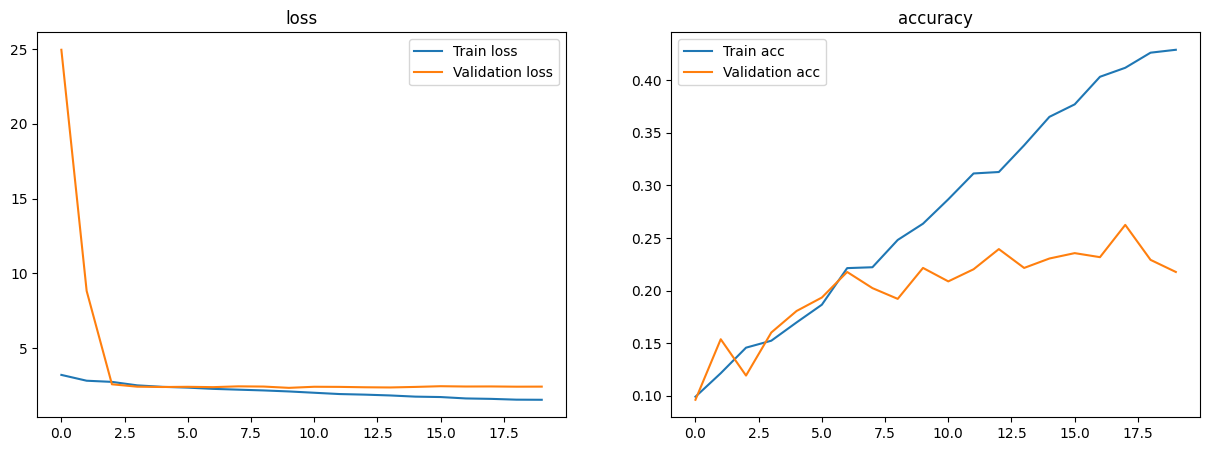

In [10]:
plot_history(history)

In [ ]:
# baseline_model.save(f"{MODELS_DIR}/baseline_model.keras")

# Predict

In [ ]:
img_path = os.path.join(
    FULL_DATA_DIR, "test", "Red-tailed_Bumble_Bee", "535031756.jpg"
)

img = load_img(img_path, target_size=IMAGE_SIZE)

img_array = img_to_array(img)

# We now have an array (224, 224, 3)
# Batch size is 1 for 1 image, our model accepts (batch_size, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)


In [21]:
pred = baseline_model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [ ]:
# Probability distribution across 12 classes
pred

array([[0.0618692 , 0.12679347, 0.09051337, 0.11306442, 0.12979054,
        0.06030054, 0.07622439, 0.09393378, 0.04390454, 0.03508817,
        0.06704979, 0.10146785]], dtype=float32)

In [24]:
# We need the maximum value:
prediction = np.argmax(pred, axis=1)
prediction

array([4])

In [25]:
train_cn, val_cn, test_cn = load_datasets()

class_names = train_cn.class_names
id_to_class = {i: name for i, name in enumerate(class_names)}

Found 3619 files belonging to 12 classes.
Found 781 files belonging to 12 classes.
Found 781 files belonging to 12 classes.


In [26]:
id_to_class

{0: 'American_Bumble_Bee',
 1: 'Brown-belted_Bumble_Bee',
 2: 'Buff-tailed_Bumble_Bee',
 3: 'Common_Carder_Bumble_Bee',
 4: 'Common_Eastern_Bumble_Bee',
 5: 'Half-black_Bumble_Bee',
 6: 'Red-belted_Bumble_Bee',
 7: 'Red-tailed_Bumble_Bee',
 8: 'Tricolored_Bumble_Bee',
 9: 'Two-spotted_Bumble_Bee',
 10: 'White-tailed_Bumble_Bee',
 11: 'Yellow-faced_Bumble_Bee'}

In [30]:
print("Predicted class:", id_to_class[prediction[0]])

Predicted class: Common_Eastern_Bumble_Bee


In [ ]:
# TODO edit shape=IMAGE_SIZE + (3,) for future models.

# 